Questionário 3

Importações e Variáveis utilizadas

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from mlxtend.plotting import plot_decision_regions


Questão 1

In [75]:
data_column = pd.read_csv('data/data/vertebralcolumn-2C.csv', header=(0))
# Dados
y = data_column.iloc[:,-1]
classes = np.array(pd.unique(y))
data = data_column.to_numpy()
nrow, ncol = data.shape
X = data[:, 0:ncol-1]

# Divisão treino/teste
p = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p, random_state=42)
feature_names = data_column.columns[:-1]

print(data_column.head(30))

    pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0          63.027817    22.552586              39.609117     40.475232   
1          39.056951    10.060991              25.015378     28.995960   
2          68.832021    22.218482              50.092194     46.613539   
3          69.297008    24.652878              44.311238     44.644130   
4          49.712859     9.652075              28.317406     40.060784   
5          40.250200    13.921907              25.124950     26.328293   
6          53.432928    15.864336              37.165934     37.568592   
7          45.366754    10.755611              29.038349     34.611142   
8          43.790190    13.533753              42.690814     30.256437   
9          36.686353     5.010884              41.948751     31.675469   
10         49.706610    13.040974              31.334500     36.665635   
11         31.232387    17.715819              15.500000     13.516568   
12         48.915551    19.964556     

Classificação Bayesiana

In [76]:
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns=classes)
Pc = np.zeros(len(classes))

for i in range(len(classes)):
    elements = np.where(y_train == classes[i])
    Pc[i] = len(elements[0]) / len(y_train)
    
    Z = X_train[elements[0], :].astype(float)  
    m = np.mean(Z, axis=0)
    cv = np.cov(Z.T)

    for j in range(X_test.shape[0]):
        x = X_test[j, :]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P.at[j, classes[i]] = pj * Pc[i] 
print("=================")
print("Médias:")
print(m)
print("=================")
print("Covariâncias:")
print(cv)
print("=================")
print(P)

Médias:
[ 51.6054354   12.52982599  43.7289935   39.07560937 123.50722877
   2.30241618]
Covariâncias:
[[152.3784421   53.01375986 109.17906071  99.36468344 -56.22856159
   13.99774286]
 [ 53.01375986  44.71068092  27.24150161   8.30307896 -20.84910594
    8.1481679 ]
 [109.17906071  27.24150161 156.4545375   81.93756048 -29.2222719
   19.89118229]
 [ 99.36468344   8.30307896  81.93756048  91.06160565 -35.37945618
    5.8495749 ]
 [-56.22856159 -20.84910594 -29.2222719  -35.37945618  80.96575249
   -1.77609637]
 [ 13.99774286   8.1481679   19.89118229   5.8495749   -1.77609637
   41.53750887]]
        Abnormal         Normal
0   7.201669e-10   1.923542e-08
1   2.610606e-11   3.048007e-16
2   2.615257e-09   2.475663e-08
3   2.685464e-10   9.204284e-26
4   1.164299e-09   2.124295e-09
5   1.897828e-09   1.395590e-11
6   4.210901e-10   1.392380e-39
7   2.469695e-10   2.823350e-16
8   2.204752e-09   3.564889e-09
9   1.768264e-09   4.491297e-09
10  1.066338e-12  4.947829e-120
11  1.777820e-1

In [77]:
y_pred = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred)
y_test = np.array(y_test)
score = accuracy_score(y_pred, y_test)
print('Precisão:', score)
print(y_pred)

Precisão: 0.8387096774193549
['Normal' 'Abnormal' 'Normal' 'Abnormal' 'Normal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Normal' 'Normal' 'Abnormal' 'Abnormal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Normal' 'Normal' 'Normal' 'Abnormal']


Classificação não paramétrica

In [78]:
P1 = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc1 = np.zeros(len(classes)) 
h = 10 # bandwitch, 10 para melhor fitting
for i in np.arange(0, len(classes)): 
    elements = tuple(np.where(y_train == classes[i])) 
    Pc1[i] = len(elements)/len(y_train) 
    Z = X_train[elements,:][0].astype(float) 
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,X_test.shape[0]): 
        x = X_test[j,:].reshape((1, -1))
        pj = np.exp(kde.score_samples(x))  
        P1.loc[j, classes[i]] = pj * Pc1[i]

y_pred1 = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P1.iloc[[i]]))
    y_pred1.append(classes[c])
y_pred1 = np.array(y_pred, dtype=str)
score = accuracy_score(y_pred1, y_test)
print('Acuracia:', score)
print(y_pred1)

Acuracia: 0.8387096774193549
['Normal' 'Abnormal' 'Normal' 'Abnormal' 'Normal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Normal' 'Normal' 'Abnormal' 'Abnormal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Normal' 'Normal' 'Normal' 'Abnormal']


Classificação Naive Bayes

In [79]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

print('Accuracy: ', model.score(X_test, y_test))
print(y_pred2)

Accuracy:  0.8064516129032258
['Normal' 'Abnormal' 'Normal' 'Abnormal' 'Normal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Abnormal' 'Normal' 'Abnormal' 'Abnormal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal' 'Abnormal'
 'Normal' 'Normal' 'Normal' 'Abnormal']


Conclusão

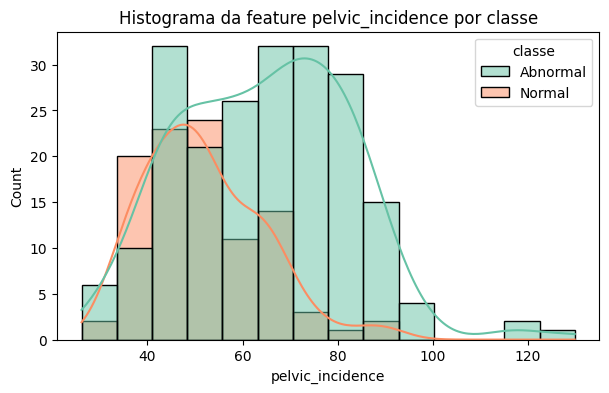

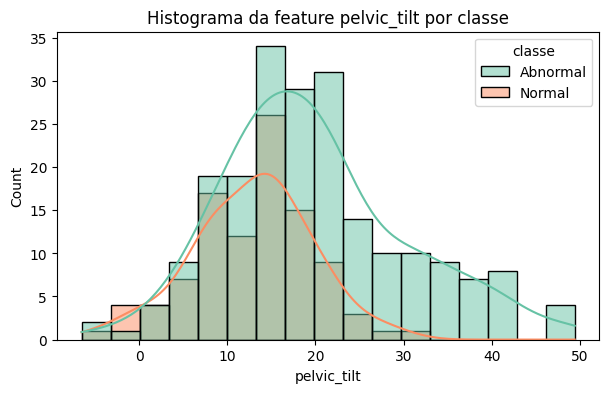

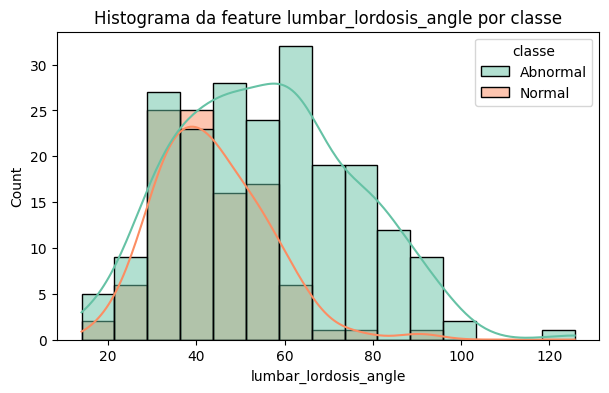

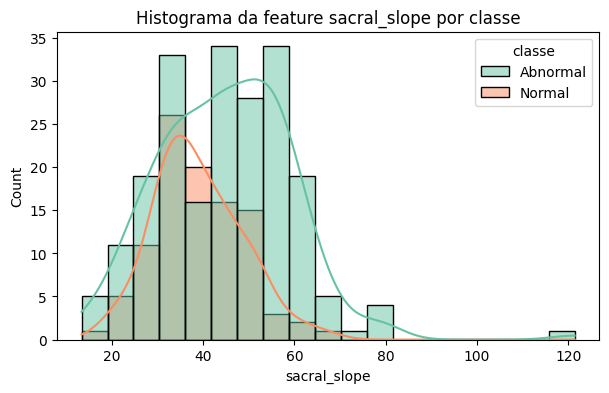

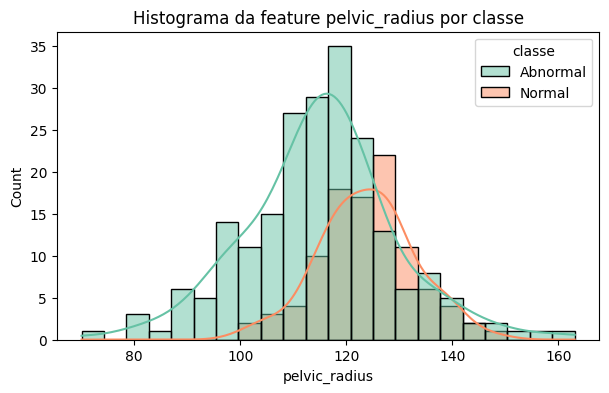

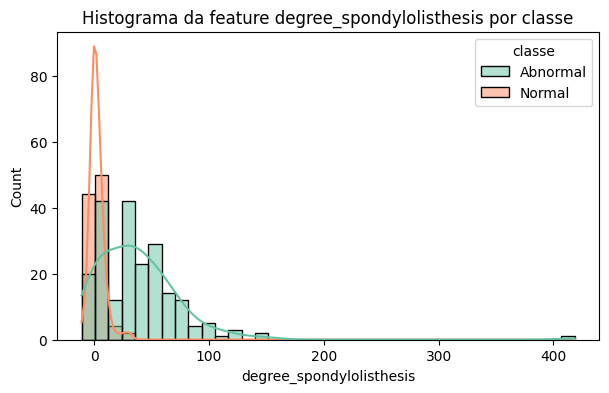

In [80]:
df = pd.DataFrame(X, columns=feature_names)
df['classe'] = y

for col in feature_names:
    plt.figure(figsize=(7,4))
    sns.histplot(data=df, x=col, hue='classe', kde=True, palette="Set2", alpha=0.5)
    plt.title(f'Histograma da feature {col} por classe')
    plt.show()

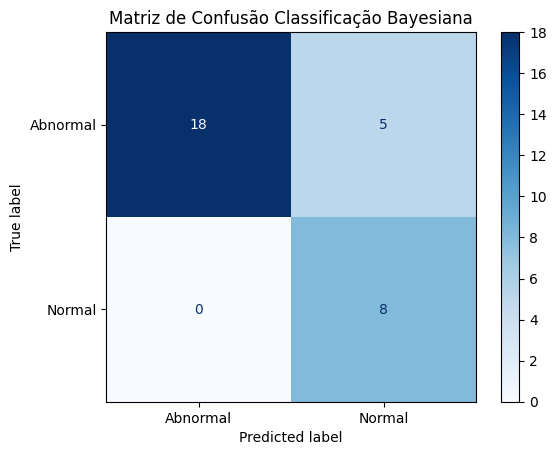

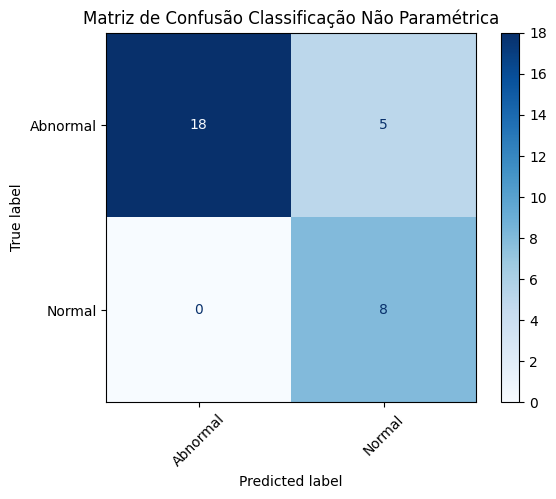

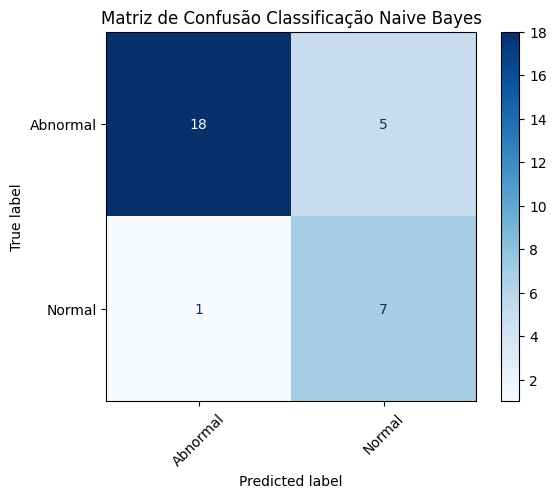

In [81]:
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão Classificação Bayesiana")
plt.show()

cm = confusion_matrix(y_test, y_pred1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão Classificação Não Paramétrica")
plt.show()

cm = confusion_matrix(y_test, y_pred2, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão Classificação Naive Bayes")
plt.show()

Pelos gráficos a seguir, temos que com um h=10, os algoritmos de classificação não parametrizada e bayesiana tem resultados semelhantes e o Naive Bayes, resultado inferior, sendo o modelo mais adequado provavelmente o não parametrizado com h otimizado.
Com isso, concluímos que supor as variáveis explicativas como multinomiais é mais adequado que supor cada classe como uma normal independente.

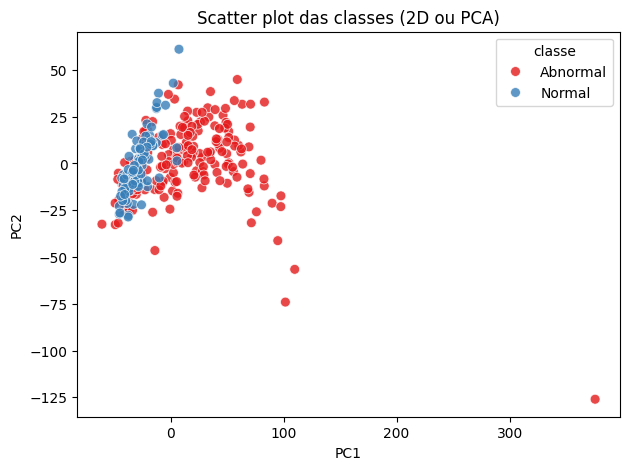

In [82]:
if X.shape[1] > 2:
    pca = PCA(n_components=2)
    X_plot = pca.fit_transform(X)
else:
    X_plot = X

df_plot = pd.DataFrame(X_plot, columns=['PC1', 'PC2'])
df_plot['classe'] = y

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='classe', palette="Set1", s=50, alpha=0.8)
plt.title("Scatter plot das classes (2D ou PCA)")
plt.show()

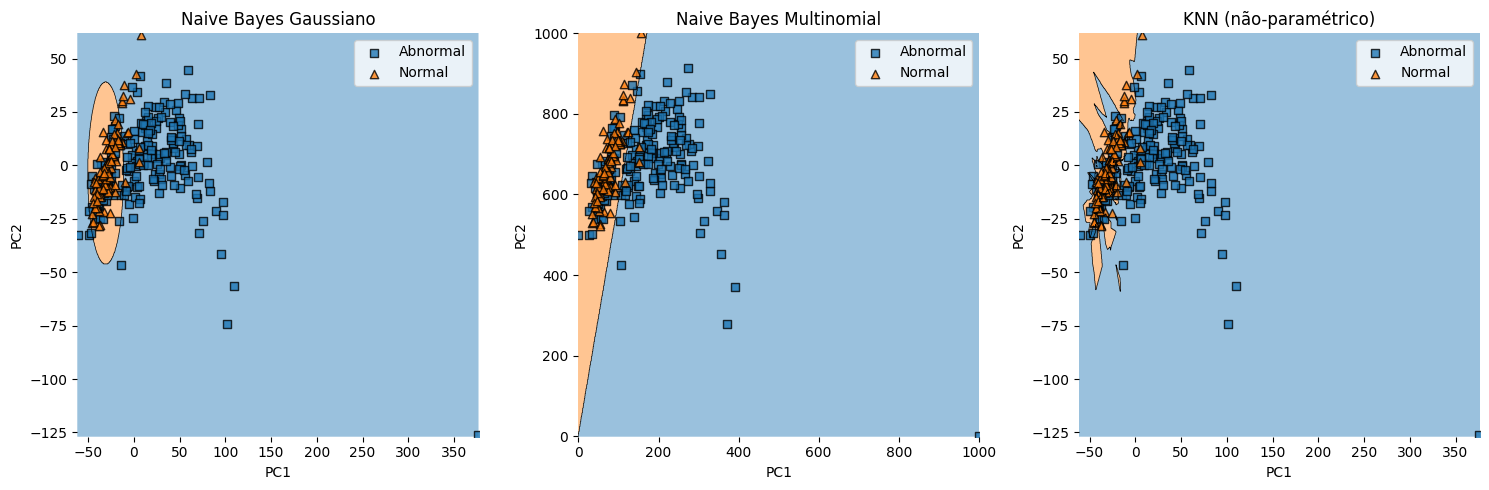

In [83]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
scaler = MinMaxScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
X_pca_counts = np.round(X_pca_scaled * 1000).astype(int)

models = {
    "Naive Bayes Gaussiano": GaussianNB(),
    "Naive Bayes Multinomial": MultinomialNB(),
    "KNN (não-paramétrico)": KNeighborsClassifier(n_neighbors=5)
}

plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    
    if name == "Naive Bayes Multinomial":
        model.fit(X_pca_counts, y_encoded)
        plot_decision_regions(X_pca_counts, y_encoded, clf=model, legend=0)
    else:
        model.fit(X_pca, y_encoded)
        plot_decision_regions(X_pca, y_encoded, clf=model, legend=0)
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(name)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = le.inverse_transform([int(lbl) for lbl in labels])
    plt.legend(handles, labels, loc="best")

plt.tight_layout()
plt.show()

(Os gráficos reduzem a dimensionalidade dos dados em duas e fazem uma aproximação dos modelos usados para uma representação gráfica complementar)

Conclusão:
Observando os resultados dos testes e os gráficos dispostos conseguimos com clareza trazer melhores conclusões sobre os dados e sobre qual é o melhor classificador dentre os analisados.
Primeiramente, analisando os histogramas percebemos que os dados não possuem simetria, apontando evidências que as VA aleatórias geradoras dos dados não são simétricas.
Observando os histogramas e o Scatter Plot com dimensionalidade dos dados reduzida para 2, podemos observar a maior dispersão dos dados anormais e maior concentração dos dados normais, onde há um ponto de encontro entre os dois de mais difícil discernimento. Isso gera um número maior de falsos negativos em comparação com falsos positivos (para a anormalidade), isso se confirma com as matrizes de confusão dos modelos, que apresentam exatamente a tese aqui descrita.
Agora observando as linhas de decisão nos 3 últimos gráficos, observa-se um crescente ajuste aos dados observados dos modelos, onde o não parametrizado é o modelo com mais ajuste aos dados. Como o resultado do modelo perante os dados de teste foi melhor no modelo não parametrizado, consideraremos que foi o melhor ajuste, que pode até ser melhorado encontrando a bandwitch otimizada. 
Concluindo, observando os resultados pelos dados de deste e pelos gráficos, concluímos que o melhor modelo é o não parametrizado. E com isso concluímos também que assumir normalidade e indepêndencia das var. Explicativas ou assumir multinormalidade são assunções inadequadas.

Questão 2

In [84]:
data_wine = pd.read_csv('data/data/winequality-red.csv', header=(0))
# Dados
y = data_wine.iloc[:,-1]
classes = np.array(pd.unique(y))
data = data_wine.to_numpy()
nrow, ncol = data.shape
X = data[:, 0:ncol-1]

# Divisão treino/teste
p = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p, random_state=42)
feature_names = data_column.columns[:-1]

print(data_wine.head(30))

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0             7.4             0.700         0.00             1.9      0.076   
1             7.8             0.880         0.00             2.6      0.098   
2             7.8             0.760         0.04             2.3      0.092   
3            11.2             0.280         0.56             1.9      0.075   
4             7.4             0.700         0.00             1.9      0.076   
5             7.4             0.660         0.00             1.8      0.075   
6             7.9             0.600         0.06             1.6      0.069   
7             7.3             0.650         0.00             1.2      0.065   
8             7.8             0.580         0.02             2.0      0.073   
9             7.5             0.500         0.36             6.1      0.071   
10            6.7             0.580         0.08             1.8      0.097   
11            7.5             0.500         0.36    

In [85]:
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) 
h_values = [0.1, 0.5, 1, 2, 4, 6, 8, 10, 12, 15, 18, 20]

for h in h_values:
    P[:] = 0  # reseta a matriz de probabilidades

    for i in range(len(classes)):
        elements = np.where(y_train == classes[i])[0]
        Pc[i] = len(elements) / len(y_train)
        Z = X_train[elements, :].astype(float)
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        
        for j in range(X_test.shape[0]):
            x = X_test[j, :].reshape((1, -1))
            pj = np.exp(kde.score_samples(x))
            P.loc[j, classes[i]] = pj * Pc[i]

    y_pred = np.array([classes[np.argmax(P.iloc[i])] for i in range(X_test.shape[0])])
    score = accuracy_score(y_pred, y_test)
    print(f'Acurácia para h={h}: {score}')

Acurácia para h=0.1: 0.525
Acurácia para h=0.5: 0.5625
Acurácia para h=1: 0.55625
Acurácia para h=2: 0.55625
Acurácia para h=4: 0.54375
Acurácia para h=6: 0.55
Acurácia para h=8: 0.5375
Acurácia para h=10: 0.5375
Acurácia para h=12: 0.54375
Acurácia para h=15: 0.525
Acurácia para h=18: 0.50625
Acurácia para h=20: 0.50625


In [86]:
h_values = np.linspace(0.1, 1, 200)  #Como o maior valor encontrado foi 0,5625, para h=0,5
best_h = None
best_score = 0
for h in h_values:
    P[:] = 0  # reseta a matriz de probabilidades

    for i in range(len(classes)):
        elements = np.where(y_train == classes[i])[0]
        Pc[i] = len(elements) / len(y_train)
        Z = X_train[elements, :].astype(float)
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
        
        for j in range(X_test.shape[0]):
            x = X_test[j, :].reshape((1, -1))
            pj = np.exp(kde.score_samples(x))
            P.loc[j, classes[i]] = pj * Pc[i]

    y_pred = np.array([classes[np.argmax(P.iloc[i])] for i in range(X_test.shape[0])])
    score = accuracy_score(y_pred, y_test)
    if score > best_score:
        best_h = h
        best_score = score

print(f'Melhor score {best_score}, para h= {best_h}')

Melhor score 0.575, para h= 0.4030150753768844


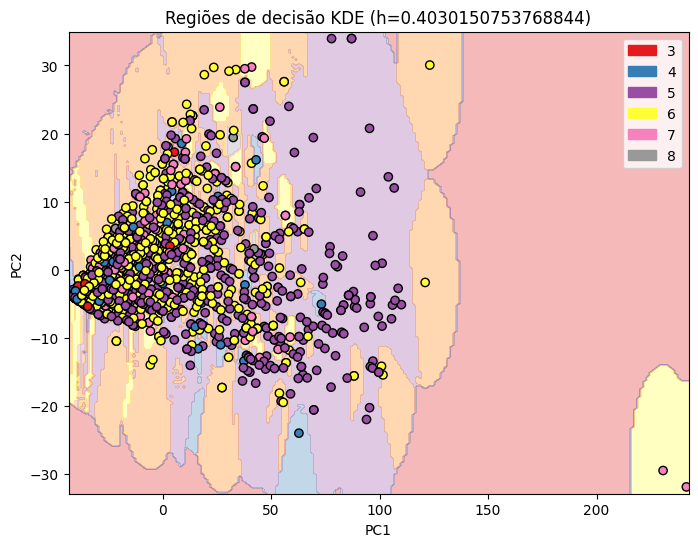

In [87]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Reduzir para 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Separar classes
classes = np.unique(y_encoded)

# Hiperparâmetro KDE
h = best_h

# Treinar um KDE para cada classe
kdes = {}
for c in classes:
    X_c = X_pca[y_encoded == c]
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X_c)
    kdes[c] = kde

# Criar grade para o gráfico
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calcular densidade para cada ponto da grade
densities = np.zeros((grid_points.shape[0], len(classes)))
for c in classes:
    densities[:, c] = np.exp(kdes[c].score_samples(grid_points))

# Atribuir classe com maior densidade
Z = np.argmax(densities, axis=1)
Z = Z.reshape(xx.shape)



# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(classes), cmap='Set1')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, edgecolor='k', cmap='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Regiões de decisão KDE (h={h})')

handles = []
colors = plt.cm.Set1(np.linspace(0, 1, len(classes)))
for i, c in enumerate(classes):
    patch = mpatches.Patch(color=colors[i], label=le.inverse_transform([c])[0])
    handles.append(patch)
plt.legend(handles=handles, loc='best')

plt.show()

Concluímos que o melhor h é 0.4030150753768844 com score de 0,575. 

Questão 3:

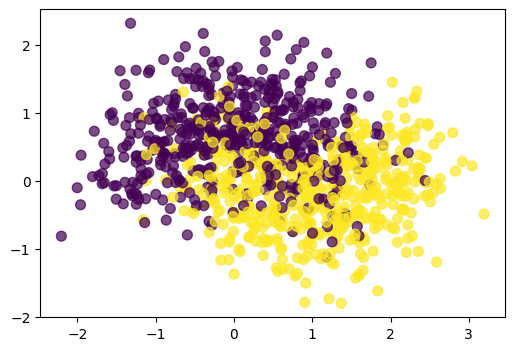

In [95]:
plt.figure(figsize=(6,4)) 
n_samples = 1000 
X, y = datasets.make_moons(n_samples=n_samples, noise=.5) 
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7) 
plt.show(True)

data_moons = pd.DataFrame(X, columns=["x1", "x2"])
data_moons["label"] = y


Supondo que queremos classificar em duas categorias: 0 e 1.

In [98]:
classes = np.array(pd.unique(y))
data = data_moons.to_numpy()
nrow, ncol = data_moons.shape
X = data_moons[["x1", "x2"]].to_numpy()
y = data_moons["label"].to_numpy()

# Divisão treino/teste
p = 0.9
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p, random_state=42)
feature_names = data_column.columns[:-1]

print(data_moons.head(30))

          x1        x2  label
0  -0.350536  0.094693      0
1   0.735695  0.658933      0
2   0.046150  0.602218      1
3   0.559608 -0.565370      1
4   0.080837  0.719758      0
5   1.124455  0.139235      0
6  -0.260823  0.940189      0
7  -0.729158  1.604928      0
8  -1.393949  1.416584      0
9   0.784406  0.309704      0
10 -0.556096  0.518339      0
11  0.537238  0.726181      0
12 -0.392585  2.165246      0
13  0.660896  0.831363      0
14  1.338313  0.308231      0
15 -0.676868  0.412802      0
16  0.596311 -1.005420      1
17  0.933254 -0.174041      1
18  3.042465  0.219473      1
19 -1.455217  1.617158      0
20  1.321144  0.184869      0
21 -0.760754  0.398965      0
22 -0.076749  0.910089      1
23  1.836207 -1.617310      1
24  1.563712 -0.468925      1
25  1.860426 -0.259421      1
26 -0.120798  0.286272      1
27 -0.312488  1.410410      0
28  0.123434  1.272132      0
29  2.831139  0.142391      1


Classificador Bayesiano

In [99]:
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns=classes)
Pc = np.zeros(len(classes))

for i in range(len(classes)):
    elements = np.where(y_train == classes[i])
    Pc[i] = len(elements[0]) / len(y_train)
    
    Z = X_train[elements[0], :].astype(float)  
    m = np.mean(Z, axis=0)
    cv = np.cov(Z.T)

    for j in range(X_test.shape[0]):
        x = X_test[j, :]
        pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
        P.at[j, classes[i]] = pj * Pc[i] 

y_pred = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred.append(classes[c])
y_pred = np.array(y_pred)
y_test = np.array(y_test)
score = accuracy_score(y_pred, y_test)
print('Precisão:', score)
print(y_pred)


Precisão: 0.79
[1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1
 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]


Classificador Naive Bayes

In [101]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

print('Accuracy: ', model.score(X_test, y_test))
print(y_pred2)

Accuracy:  0.79
[1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1
 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]


In [123]:
P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
Pc = np.zeros(len(classes)) 
h = 5 # bandwitch, 10 para melhor fitting
for i in np.arange(0, len(classes)): 
    elements = tuple(np.where(y_train == classes[i])) 
    Pc[i] = len(elements)/len(y_train) 
    Z = X_train[elements,:][0].astype(float) 
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
    for j in np.arange(0,X_test.shape[0]): 
        x = X_test[j,:].reshape((1, -1))
        pj = np.exp(kde.score_samples(x))  
        P.loc[j, classes[i]] = pj * Pc[i]

y_pred1 = []
for i in np.arange(0, X_test.shape[0]):
    c = np.argmax(np.array(P.iloc[[i]]))
    y_pred1.append(classes[c])
y_pred1 = np.array(y_pred1, dtype=int)
score = accuracy_score(y_pred1, y_test)
print('Acuracia:', score)
print(y_pred1)

Acuracia: 0.81
[1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1
 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0
 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]


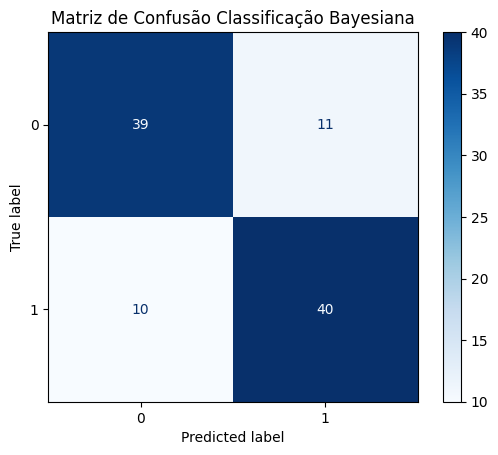

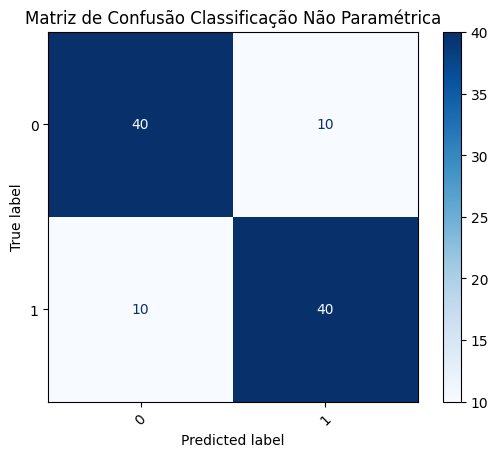

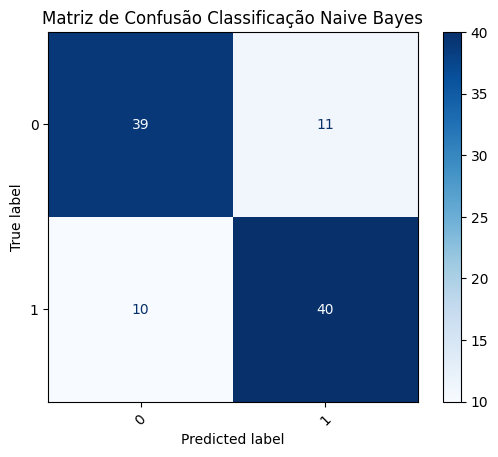

In [107]:
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão Classificação Bayesiana")
plt.show()

cm = confusion_matrix(y_test, y_pred1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão Classificação Não Paramétrica")
plt.show()

cm = confusion_matrix(y_test, y_pred2, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão Classificação Naive Bayes")
plt.show()

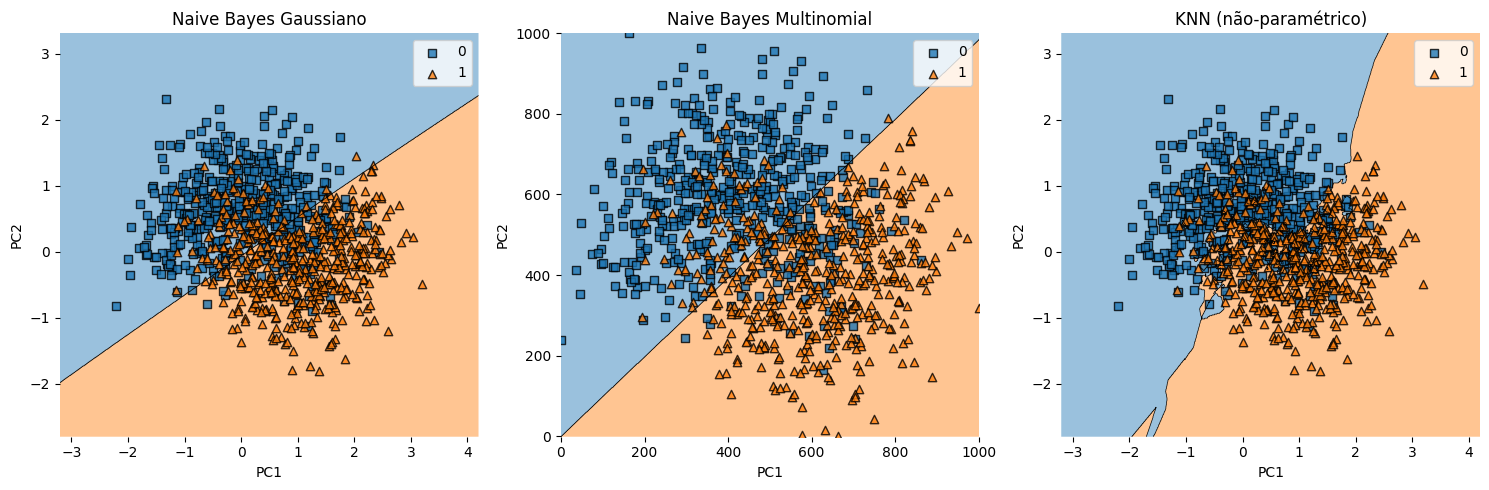

In [126]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_counts = np.round(X_scaled * 1000).astype(int)

models = {
    "Naive Bayes Gaussiano": (GaussianNB(), X),
    "Naive Bayes Multinomial": (MultinomialNB(), X_counts),
    "KNN (não-paramétrico)": (KNeighborsClassifier(n_neighbors=5), X),
}

# 4. Plotar decision regions
plt.figure(figsize=(15, 5))

for i, (name, (model, X_used)) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    
    if name == "Naive Bayes Multinomial":
        model.fit(X_counts, y)
        plot_decision_regions(X_counts, y, clf=model, legend=0)
    else:
        model.fit(X, y)
        plot_decision_regions(X, y, clf=model, legend=0)
    
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(name)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc="best")

plt.tight_layout()
plt.show()

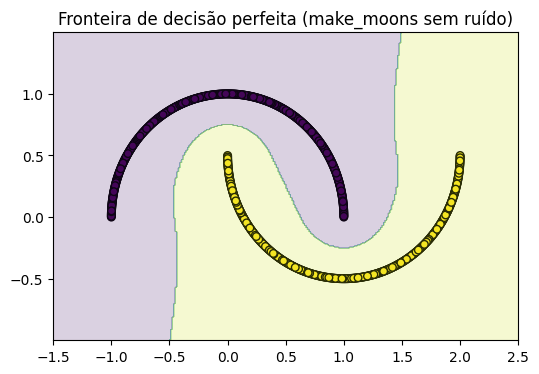

Acurácia da linha de decisão perfeita: 0.83


In [129]:
X_clean, y_clean = datasets.make_moons(n_samples=1000, noise=0.0, random_state=42)

# Treinar KNN superflexível (k=1) para capturar a fronteira perfeita
knn_perfect = KNeighborsClassifier(n_neighbors=1)
knn_perfect.fit(X_clean, y_clean)

# Criar malha para plot
xx, yy = np.meshgrid(np.linspace(X_clean[:,0].min()-0.5, X_clean[:,0].max()+0.5, 300),
                     np.linspace(X_clean[:,1].min()-0.5, X_clean[:,1].max()+0.5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Prever cada ponto da malha
y_grid = knn_perfect.predict(grid)

# Plot
plt.figure(figsize=(6,4))
plt.scatter(X_clean[:,0], X_clean[:,1], c=y_clean, cmap="viridis", s=30, edgecolor="k")

# Fronteira de decisão perfeita
plt.contourf(xx, yy, y_grid.reshape(xx.shape), alpha=0.2, cmap="viridis")

plt.title("Fronteira de decisão perfeita (make_moons sem ruído)")
plt.show()

y_pred = knn_perfect.predict(X_test)

# Avaliar acurácia
acc = accuracy_score(y_test, y_pred)
print("Acurácia da linha de decisão perfeita:", acc)

É importante lembrar que o erro obtido na linha ideal se dá pela variância da VA. Essa seria a acurácia máxima dos modelos. Logo o modelo está a 2% da linha ideal

Pelos testes e pelos gráficos, percebemos que o caracterizador não paramétrico obteve melhor resultado.
Além de obter melhores resultados, ele é o que mais se aproxima da linha de decisão ideal, tendo um melhor delineado